In [1]:
# Import Statements


%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from tensorboardX import SummaryWriter
from datetime import datetime
import importlib


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
color = sns.color_palette()


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
num_classes=5


#from torchsample.transforms import RangeNorm

import functions.fine_tune as ft

plt.ion()   # interactive mode

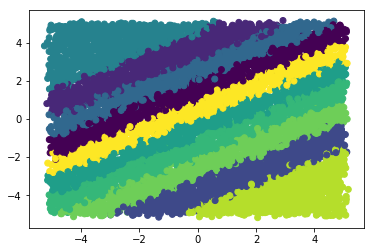

In [2]:
num_classes = 10
dim = 2

def generateLinearData(num_samples = 10000, num_classes = num_classes, dim = dim, bound = 5, sigma_noise = .1,rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
        
    fvec = np.random.rand(dim, num_samples)*bound*2-bound
    label = np.dot((np.random.rand(1,dim)*bound*2-bound).reshape(1,-1),fvec)

    sorted_idx = np.argsort(label)
    bin_size = label.shape[1]/num_classes

    for k in range(0, num_classes):
        label[0, sorted_idx[0, np.floor(k*bin_size).astype(int):np.floor((k+1)*bin_size).astype(int)]] = rand_classes[k]

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

fvec, label = generateLinearData(rand_label = True)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label)


(1, 10000)


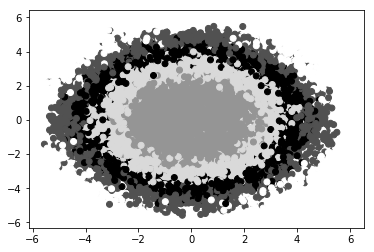

In [3]:
def generateCircularData(num_samples = 10000, num_classes = num_classes, dim = dim,
                         bound = 5, sigma_noise = .1, rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
        
    fvec = np.random.rand(dim, num_samples)*bound*2-bound
    
    fvec_l = np.sum(fvec**2, axis = 0).reshape(1,-1)
    print(fvec_l.shape)
    label = fvec_l

    sorted_idx = np.argsort(label)
    bin_size = label.shape[1]/num_classes

    for k in range(0, num_classes):
        label[0, sorted_idx[0, np.floor(k*bin_size).astype(int):np.floor((k+1)*bin_size).astype(int)]] = rand_classes[k]

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

fvec, label = generateCircularData(num_classes =5, sigma_noise = .3, rand_label = True)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label, cmap = plt.get_cmap('Greys'))


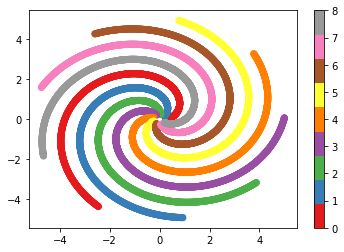

In [4]:
def generateSpiralData(num_samples = 10000, num_classes = num_classes, dim = dim,
                         bound = 5, sigma_noise = .1, rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
    
    #rand_classes = [1, 1.5, -1, -1.5]
    sample_per_class = int(num_samples/num_classes)
    num_samples = sample_per_class*num_classes
    fvec = np.zeros((dim, sample_per_class*num_classes))
    label = np.zeros((1, sample_per_class*num_classes))
    
    t = np.linspace(0, 10, sample_per_class)
    x = t * np.cos(t)
    y = t * np.sin(t)
    x = x.reshape(1, -1)
    y = y.reshape(1, -1)

    cons = .7
    for k in range(0, num_classes):
        r = np.linspace(0.05, 1, sample_per_class)
        t = np.linspace(k*cons, (k+6)*cons, sample_per_class)
        x = np.cos(t)
        y = np.sin(t)
        x = x.reshape(1, -1)
        y = y.reshape(1, -1)
        label[0, k*sample_per_class:(k+1)*sample_per_class] = rand_classes[k]
        fvec[0, k*sample_per_class:(k+1)*sample_per_class] = bound * x * r
        fvec[1, k*sample_per_class:(k+1)*sample_per_class] = bound * y * r

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

fvec, label = generateSpiralData(num_classes = 9, sigma_noise = 0, rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label, cmap = plt.get_cmap('Set1'))
plt.colorbar()


# Train an MLP network

In [5]:
def make_coeff(n, metric, lmbda = 1):
    if metric is 'ccr':
        return [1]
    elif metric is 'ccr1':
        return [1, 1, 1]
    elif metric is 'mae':
        coeff = np.arange(1,n)/(n-1)
    elif metric is 'mse':
        coeff = np.zeros(n-1)
        coeff[0] = 2*n-3
        for k in range(1, n-1):
            coeff[k] = coeff[k-1] + 2*n - (2*(k+1)+1)
        coeff = coeff /((n-1)**2)
    else:
        print('Undefined Metric: ' + metric)
    coeff = np.concatenate((coeff, coeff[::-1][1:]), axis=0)
    coeff = coeff * lmbda
    coeff[n-2] = 1
    return coeff

In [6]:
data_type = 'spiral'
num_samples = 10000
num_classes = 9
nclasses = num_classes
dim = 2

sigma_noise = 0.1
optimizer='sgd' #Optimizer function
iter_loc=7 #Number of the first column in the excel file for writing the results.
lr=.5 #Initial learning rate
momentum=0.9
weight_decay=0.0005
batch_size = 64
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay
hidden_sizes = [4]
dropouts = [1]
rand_label = False

metric = 'ccr1'
coeff_lmbda =  1
multi_coeff = make_coeff(nclasses, metric, coeff_lmbda)
KL = False #KL divergence for porbability measure


'''Multipliers for loss functions'''
single_loss=0.
multi_loss=1.

comment=' ' #Additional comments if any



In [7]:


if data_type == 'circular':
    fvec, label = generateCircularData(num_samples = num_samples, 
                                       num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
elif data_type == 'linear':
    fvec, label = generateLinearData(num_samples = num_samples, 
                                     num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
elif data_type == 'spiral':
    fvec, label = generateSpiralData(num_samples = num_samples, 
                                     num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
else:
    print('!!!! WRONG DATA TYPE')

fvec_norm = (fvec)/5
mid_point = int(len(label)/2)#100*num_classes
fvec_test = fvec_norm[:mid_point,:]
fvec_train = fvec_norm[mid_point:,:]

label_test = label[:mid_point]
label_train = label[mid_point:]

print(np.max(fvec_train))
print(np.min(fvec_train))

torch.from_numpy(label_train).type(torch.LongTensor)
dsets={'train': torch.utils.data.TensorDataset(torch.from_numpy(fvec_train).type(torch.FloatTensor),
                                               torch.from_numpy(label_train).type(torch.LongTensor)),
       'val': torch.utils.data.TensorDataset(torch.from_numpy(fvec_test).type(torch.FloatTensor),
                                             torch.from_numpy(label_test).type(torch.LongTensor))}

'''Define dataset loaders'''
dset_loaders = {'train':torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size,shuffle=True,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dsets['val'], batch_size=batch_size,shuffle=False,
                                                    num_workers=12)}


dset_sizes={'train':len(dsets['train']),'val':len(dsets['val'])}
use_gpu = torch.cuda.is_available()

print(dset_sizes)

if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

inputs, classes = next(iter(dset_loaders['train']))
print(inputs.shape)


1.00471383034
-0.993487628457
{'train': 5000, 'val': 4999}
GPU is available
torch.Size([64, 2])


In [8]:
def writeLog(logname):
    '''
    Creates a text file named Network_properties.txt inside runs/'logname'
    '''
    f=open('runs_regression/'+logname+'/Network_properties.txt','w')
    f.write('Feature Length: '+str(dim)+'\n')
    f.write('Number of classes: '+str(num_classes)+'\n')
    f.write('Data type: '+data_type+'\n')
    f.write('Random Noise: '+str(sigma_noise)+'\n')
    
    f.write('Hidden sizes: '+ str(hidden_sizes)+'\n')
    f.write('Dropouts: '+str(dropouts)+'\n')
    f.write('Batch size: '+str(batch_size)+'\n')
    f.write('Number of samples: '+str(num_samples)+'\n')
    
    f.write('Optimizer: ' + optimizer + '\n')
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    f.write('Criterion: '+crt+'\n')
    f.write('Learning rate: '+str(lr)+'\n')
    f.write('Momentum: '+str(momentum)+'\n')
    f.write('Leraning Rate Scheduler: '+str(lr_scheduler)+'\n')
    f.write('Leraning Rate Decay Period: '+str(lr_decay_epoch)+'\n')
    f.close()

In [15]:
import openpyxl
import time

def writeLog_xlsx(logname='logs_regression.xlsx',iter_loc=8):
    '''
    Adds a line to logs.xlsx with the network properties and outcomes.
    :param iter_loc: First column to record the outcomes.
    '''
    book = openpyxl.load_workbook(logname)
    sheet = book.active
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    multi_coeff = make_coeff(nclasses, metric, coeff_lmbda)
    specs=(datetime.now().strftime('%B%d  %H:%M:%S'),str(hidden_sizes),str(dim),str(num_classes),
           crt, str(lr), str(multi_coeff))
    sheet.append(specs)
    current_row = sheet.max_row
    sheet.cell(row=current_row, column=iter_loc+5).value = comment
    book.save(logname)

In [10]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropouts, num_classes):
        super(Net, self).__init__()
        self.numHidden=len(hidden_sizes)
        setattr(self, 'fc0', nn.Linear(input_size, hidden_sizes[0]))
        setattr(self, 'relu0', nn.ReLU())
        #setattr(self, 'drop0', nn.Dropout(p=dropouts[0]))
        for k in range(len(hidden_sizes)-1):
            setattr(self, 'fc'+str(k+1), nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
            setattr(self, 'relu'+str(k+1), nn.ReLU())
            #setattr(self, 'drop'+str(k+1), nn.Dropout(p=dropouts[k+1]))
        setattr(self, 'fc'+str(len(hidden_sizes)), nn.Linear(hidden_sizes[-1], num_classes))
    
    def forward(self, x):
        out=self.fc0(x)
        out = self.relu0(out)
        #out = self.drop0(out)
        for k in range(self.numHidden-1):
            fc = getattr(self,'fc'+str(k+1))
            relu = getattr(self,'relu'+str(k+1))
            #drop = getattr(self,'drop'+str(k+1))
            out = fc(out)
            out = relu(out)
            #out = drop(out)
        fc = getattr(self,'fc'+str(self.numHidden))
        out = fc(out)
        return out
    
model=Net(2, [4, 2],[1, 1], 2)
print(model)

Net(
  (fc0): Linear(in_features=2, out_features=4)
  (relu0): ReLU()
  (fc1): Linear(in_features=4, out_features=2)
  (relu1): ReLU()
  (fc2): Linear(in_features=2, out_features=2)
)


In [11]:
def network_loader(comment=comment,
                    optimizer=optimizer,
                    iter_loc=iter_loc,
                    lr=lr,
                    momentum=momentum,
                    weight_decay=weight_decay,
                    lr_scheduler=lr_scheduler,
                    lr_decay_epoch=lr_decay_epoch,
                    nclasses=num_classes,
                    hidden_sizes = hidden_sizes,
                    dropouts = dropouts):
    
    '''Load the network from pytorch'''
    
    model_ft = Net(dim, hidden_sizes , dropouts, num_classes)

    if use_gpu:
        model_ft = model_ft.cuda()

    '''Define the optimizer function'''
    if(optimizer=='adam'):
        optimizer_ft = optim.Adam(model_ft.parameters(),lr=lr,weight_decay=weight_decay)
    elif(optimizer=='sgd'):
        if(end_to_end):
            optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)
    return model_ft, optimizer_ft

In [12]:
def write_epochs(result_log, logname):
    print(len(result_log))

    wb_tr = openpyxl.Workbook()
    ws_tr = wb_tr.active
    wb_val = openpyxl.Workbook()
    ws_val = wb_val.active
    print(logname)

    label_arr_tr = np.zeros((100000,1))
    probs_arr_tr = np.zeros((100000, num_classes))
    label_arr_val = np.zeros((100000,1))
    probs_arr_val = np.zeros((100000, num_classes))

    prev_epoch = 0
    
    count_tr = count_val = 0
    for result in result_log:
        epoch = result[1]
        if not epoch == prev_epoch:
            label_arr_tr = label_arr_tr[:count_tr]
            probs_arr_tr = probs_arr_tr[:count_tr, :]
            label_arr_val = label_arr_val[:count_val]
            probs_arr_val = probs_arr_val[:count_val, :]
            ws_tr.append(['Epoch ' + str(prev_epoch)])
            ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
            ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_tr[1:,:].T.tolist():
                ws_tr.append(probs)
            #wb_tr.save('./runs_ord/'+logname + '/train.xlsx')
            ws_val.append(['Epoch ' + str(prev_epoch)])
            ws_val.append(label_arr_val[1:].reshape(-1).tolist())
            ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_val[1:,:].T.tolist():
                ws_val.append(probs)
    

            label_arr_tr = np.zeros((100000,1))
            probs_arr_tr = np.zeros((100000, num_classes))
            label_arr_val = np.zeros((100000,1))
            probs_arr_val = np.zeros((100000, num_classes)) 
            count_tr = count_val = 0
            prev_epoch = epoch

        label = np.asarray(result[2]).reshape(-1,1)
        scores = np.asarray(result[3])
        exp_scores = np.exp(scores - np.max(scores,axis=1).reshape(-1, 1)*np.ones(num_classes))
        probs = np.round(exp_scores/(np.sum(exp_scores,axis=1).reshape(-1, 1)*np.ones(num_classes)), decimals=2)
        if result[0] == 'train':
            label_arr_tr[count_tr:count_tr + len(label)]  = label
            probs_arr_tr[count_tr:count_tr + len(label), :] = probs
            count_tr += len(label)
        elif result[0] == 'val':
            label_arr_val[count_val:count_val + len(label)]  = label
            probs_arr_val[count_val:count_val + len(label), :] = probs
            count_val += len(label)


    
    label_arr_tr = label_arr_tr[:count_tr]
    probs_arr_tr = probs_arr_tr[:count_tr, :]
    label_arr_val = label_arr_val[:count_val]
    probs_arr_val = probs_arr_val[:count_val, :]
            
    ws_tr.append(['Epoch ' + str(epoch)])
    ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
    ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_tr[1:,:].T.tolist():
        ws_tr.append(probs)
    #wb_tr.save('./runs_ord/'+logname + '/train.xlsx')
    ws_val.append(['Epoch ' + str(epoch)])
    ws_val.append(label_arr_val[1:].reshape(-1).tolist())
    ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_val[1:,:].T.tolist():
        ws_val.append(probs)
    wb_val.save('./runs_regression/'+logname + '/val.xlsx')
    label_arr_tr = np.zeros((1,1))
    probs_arr_tr = np.zeros((1, num_classes))
    label_arr_val = np.zeros((1,1))
    probs_arr_val = np.zeros((1, num_classes))
    prev_epoch = epoch
    print('Finito')
    
    del label_arr_tr, probs_arr_tr, label_arr_val, probs_arr_val


In [13]:
importlib.reload(ft)
    
def run_network():
    '''
    Cretaes the log files and starts the training
    '''
    model_ft, optimizer_ft = network_loader(comment=comment, #'Tested for three rooms'
                                            optimizer=optimizer,
                                            iter_loc=iter_loc,
                                            lr=lr,
                                            momentum=momentum,
                                            weight_decay=weight_decay,
                                            lr_scheduler=lr_scheduler,
                                            lr_decay_epoch=lr_decay_epoch,
                                            nclasses=num_classes)
    
    
    '''Name of the trial'''
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    logname='Ordinal_'+datetime.now().strftime('%B%d  %H:%M:%S')
    writer = SummaryWriter('runs_regression/'+logname) #For tensorboard
    writeLog(logname)
    writeLog_xlsx()
    
    '''Start trianing'''
    multi_coeff = make_coeff(nclasses, metric, coeff_lmbda)
    best_model, last_model, result_log = ft.train_model(model_ft,optimizer_ft, lr_scheduler,dset_loaders,
                            dset_sizes,writer,use_gpu=use_gpu,num_epochs=50,batch_size=batch_size,num_log=250,
                            multi_prob=False,lr_decay_epoch=lr_decay_epoch,init_lr=lr,mse_loss=False,
                            iter_loc=iter_loc,cross_loss=single_loss,multi_loss=multi_loss,numOut=num_classes,
                            logname='logs_regression.xlsx',
                            multi_coeff = multi_coeff, single_coeff = multi_coeff, KL = KL)
    
    '''Save the models'''
    torch.save(best_model,'./saved_models/ord/'+logname+'_best')
    torch.save(last_model,'./saved_models/ord/'+logname+'_last')
    
    print('Writing results')
    write_epochs(result_log, logname)
    print('Wrote results')
    '''Free up the memory'''
    del model_ft, result_log
    
    return last_model


In [18]:
end_to_end = True
optimizer='adam' #Optimizer function
lr=0.05 #Initial learning rate
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay

hidden_sizes = [4, 4, 4]
dropouts = []
single_loss=1.0
multi_loss =0.0
KL = True

metric = 'ccr'
run_network()

Multi_coef is [1]
Epoch 0/49
----------
LR is set to 0.05


/media/mtezcan/New Volume/amazon/notebook/functions/fine_tune.py:138: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs_log_softmax = log_soft(outputs)


train Loss: 0.0025 Acc: 0.3200 CIR-1: 0.7262 RMSE 1.3680
val Loss: 0.0116 Acc: 0.0000 CIR-1: 0.1000 RMSE 5.6416

Epoch 1/49
----------
train Loss: 0.0021 Acc: 0.4070 CIR-1: 0.8466 RMSE 1.1127
val Loss: 0.0127 Acc: 0.0000 CIR-1: 0.1374 RMSE 5.2590

Epoch 2/49
----------
train Loss: 0.0019 Acc: 0.4876 CIR-1: 0.9226 RMSE 0.9543
val Loss: 0.0143 Acc: 0.0000 CIR-1: 0.1132 RMSE 5.1980

Epoch 3/49
----------
train Loss: 0.0019 Acc: 0.5096 CIR-1: 0.9304 RMSE 0.9128
val Loss: 0.0150 Acc: 0.0000 CIR-1: 0.1232 RMSE 5.4394

Epoch 4/49
----------
train Loss: 0.0018 Acc: 0.5400 CIR-1: 0.9364 RMSE 0.8977
val Loss: 0.0154 Acc: 0.0000 CIR-1: 0.1284 RMSE 5.4869

Epoch 5/49
----------
train Loss: 0.0018 Acc: 0.5424 CIR-1: 0.9372 RMSE 0.8955
val Loss: 0.0155 Acc: 0.0000 CIR-1: 0.1314 RMSE 5.4096

Epoch 6/49
----------
train Loss: 0.0018 Acc: 0.5668 CIR-1: 0.9338 RMSE 0.8865
val Loss: 0.0159 Acc: 0.0000 CIR-1: 0.1324 RMSE 5.2345

Epoch 7/49
----------
train Loss: 0.0018 Acc: 0.5582 CIR-1: 0.9360 RMSE 0.888

KeyboardInterrupt: 

# Analysis